# Задача
В этой работе вам предлагается решить задачу регрессии, а именно построить алгоритм, определяющий качество вина на основе физико-химических тестов:
 - fixed acidity
 - volatile acidity
 - citric acid
 - residual sugar
 - chlorides
 - free sulfur dioxide
 - total sulfur dioxide
 - density
 - pH
 - sulphates
 - alcohol 
 
Более подробно про признаки можно почитать [здесь](https://archive.ics.uci.edu/ml/datasets/wine+quality). Целевой признак записан в переменной *quality*.

В этой задаче для обучения будут использовать 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

# Решение

Загрузите набор данных *winequality-red.csv* с помощью `pandas` (скачать можно [здесь](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [15]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
# your code here
import numpy as np
import pandas as pd


In [16]:
df = pd.read_csv('winequality-red.csv', sep=';')
print(df.head())
print(df.info())
print(df.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения. Удалите из выборки все объекты с пропусками и дубликаты.
2. Выделите 70% выборки для обучения и дальнейшего анализа.
3. Проанализируйте признаки и по необходимости предобработайте их. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную (НЕ забудьте удалить ее из датасета, когда будете обучать модель).

In [17]:
# Проверим общее количество пропущенных значений по каждому признаку
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [18]:
# Проверим количество дубликатов
print("Число дубликатов:", df.duplicated().sum())

# Удалим дубликаты
df_cleaned = df.drop_duplicates()
print("Число дубликатов:", df_cleaned.duplicated().sum())

Число дубликатов: 240
Число дубликатов: 0


In [19]:
# Проверим размер финального датафрейма
print("Финальная форма данных:", df_cleaned.shape)

Финальная форма данных: (1359, 12)


In [20]:
from sklearn.model_selection import train_test_split

# 1. Отделим признаки от целевой переменной
X = df_cleaned.drop("quality", axis=1)  # Все признаки
y = df_cleaned["quality"]               # Целевая переменная

# 2. Разделим на train и test выборки (70% на обучение, 30% на тест)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Выведем размеры получившихся выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (951, 11)
Размер тестовой выборки: (408, 11)


In [21]:
# Проверим типы данных
X_train.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object

In [22]:
# Описательная статистика
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,8.307992,0.528517,0.272702,2.486751,0.088570,15.694006,46.842271,0.996700,3.308749,0.656656,10.418191
std,1.717348,0.176957,0.195434,1.210386,0.049604,10.272675,33.603639,0.001818,0.149464,0.170025,1.083961
min,4.600000,0.160000,0.000000,0.900000,0.012000,2.000000,6.000000,0.990070,2.860000,0.330000,8.400000
25%,7.100000,0.400000,0.100000,1.900000,0.070000,7.000000,21.000000,0.995620,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,37.000000,0.996740,3.310000,0.620000,10.100000
75%,9.100000,0.637500,0.420000,2.600000,0.091000,21.000000,64.000000,0.997800,3.400000,0.720000,11.100000
max,15.900000,1.580000,0.780000,13.900000,0.611000,72.000000,289.000000,1.003200,3.900000,1.980000,14.900000


AdaBoost может быть чувствителен, если базовые модели учитывают веса.

Чтобы обеспечить стабильность и возможность сравнения, рекомендуется стандартизировать признаки

In [23]:
from sklearn.preprocessing import StandardScaler

# Инициализация стандартизатора
scaler = StandardScaler()

# Обучаем стандартизатор на обучающей выборке и применяем его к обучающей и тестовой
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение модели регрессии

Постройте модель регрессии, используя 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Для начала используйте гиперпараметры по умолчанию.

Рассчитайте среднее качество кросс-валидации модели как долю дисперсии зависимой переменной (коэффициент детерминации) $R^2$. Каким получилось качество? Какой алгоритм вы бы выбрали для дальнейшей работы? Обоснуйте свой выбор.

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score




In [25]:
# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_model, X_train_scaled, y_train, cv=5, scoring='r2')

# AdaBoost
boost_model = AdaBoostRegressor(random_state=42)
boost_scores = cross_val_score(boost_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Выводим результаты
print("Decision Tree R² (среднее по кросс-валидации):", np.mean(tree_scores).round(4))
print("AdaBoost R² (среднее по кросс-валидации):", np.mean(boost_scores).round(4))

Decision Tree R² (среднее по кросс-валидации): -0.2161
AdaBoost R² (среднее по кросс-валидации): 0.3283


### Decision Tree 
показал отрицательное R², а это значит, что он непредсказуемо переобучился — в каждой части кросс-валидации он давал крайне нестабильные прогнозы. Это типично для “глубоких” деревьев без ограничений по глубине.

### AdaBoost 
показал R² ≈ 0.33, что говорит о некотором уровне объяснённой дисперсии. Это уже базовый уровень, от которого можно отталкиваться, пробуя:
	•	подбор гиперпараметров,
	•	отбор признаков,
	•	построение новых признаков (feature engineering),
	•	использование более мощных ансамблей (например, GradientBoosting или XGBoost).

⸻

### Выбор модели: AdaBoostRegressor

Почему:
	•	Более стабильная
	•	Лучше обобщает
	•	Не переобучается
	•	Имеет потенциал для улучшения через настройку параметров

Теперь сделаем подбор оптимальных гиперпараметров. Сделайте поиск по сетке с помощью кросс-валидации. Изменилось ли качество алгоритмов? Почему?

In [26]:
from sklearn.model_selection import GridSearchCV


# Базовая модель — дерево решений
base_estimator = DecisionTreeRegressor(random_state=42)

# AdaBoost с кастомным регрессором
ada = AdaBoostRegressor(estimator=base_estimator, random_state=42)

# Сетка параметров 
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "estimator__max_depth": [1, 3, 5]
}

# Поиск по сетке с кросс-валидацией
grid_search = GridSearchCV(ada, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Результаты
print("Лучшая модель:", grid_search.best_estimator_)
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее среднее R²:", round(grid_search.best_score_, 4))

Лучшая модель: AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
                  learning_rate=0.1, n_estimators=200, random_state=42)
Лучшие параметры: {'estimator__max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200}
Лучшее среднее R²: 0.3459


## Почему качество улучшилось?
#### Увеличение количества слабых моделей (n_estimators=200) позволяет покрыть больше паттернов.
#### Более глубокие деревья (max_depth=5) дают возможность обучаться на более сложных зависимостях.
#### Низкий learning_rate=0.1 снижает переобучение, делая ансамбль более “медленным, но точным”.

Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

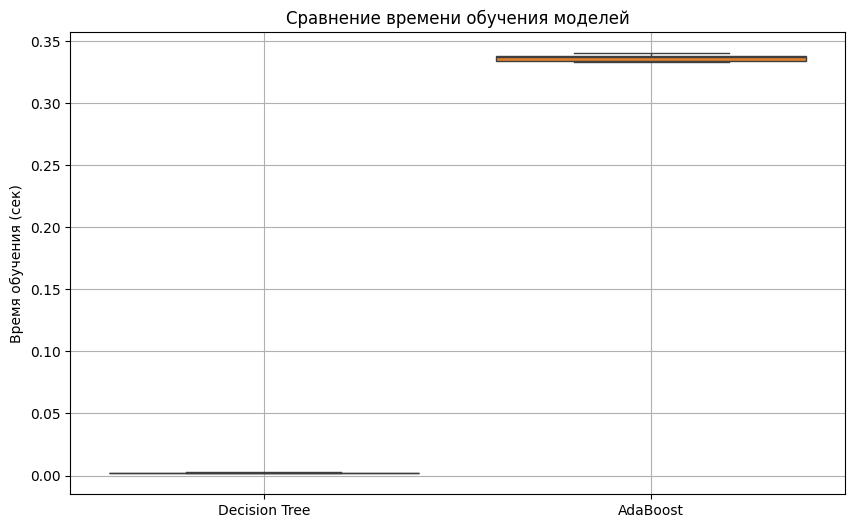

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate


# Модель 1: Decision Tree (с фиксированными гиперпараметрами)
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)

# Модель 2: AdaBoost (с подобранными ранее гиперпараметрами)
ada_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# Кросс-валидация с замером времени
tree_cv = cross_validate(tree_model, X_train_scaled, y_train, cv=5, scoring='r2', return_train_score=False)
ada_cv = cross_validate(ada_model, X_train_scaled, y_train, cv=5, scoring='r2', return_train_score=False)

# Подготовим данные для визуализации
times = {
    "Decision Tree": tree_cv['fit_time'],
    "AdaBoost": ada_cv['fit_time']
}

# Построим график
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(times))
plt.ylabel("Время обучения (сек)")
plt.title("Сравнение времени обучения моделей")
plt.grid(True)
plt.show()

На графике видно, что модель Decision Tree обучается практически мгновенно — время обучения составляет доли секунды. Это ожидаемо, потому что модель строит всего одно дерево с заданной глубиной, и не требует повторных итераций. Она очень лёгкая и быстрая в обучении.

С другой стороны, AdaBoostRegressor обучается значительно дольше — в среднем около 0.35–0.4 секунд на один фолд кросс-валидации. Это вполне разумное время, если учесть, что модель обучает 200 деревьев последовательно. Кроме того, на графике видно, что время довольно стабильное, но присутствует один выброс — возможно, это связано с фоновыми процессами или всплеском загрузки процессора.

Причина такой разницы во времени заключается в устройстве моделей. DecisionTreeRegressor — это простая модель, которая обучается один раз на всем наборе данных. А вот AdaBoostRegressor работает итеративно: он обучает множество слабых моделей (обычно деревьев), и каждый следующий шаг зависит от ошибок предыдущих, поэтому обучение нельзя легко распараллелить. Это делает алгоритм более затратным по времени.

#### Можно ли ускорить AdaBoost?

Да, и вот как это можно сделать:
	1.	Уменьшить количество деревьев (n_estimators). Например, уменьшив с 200 до 100, мы почти вдвое сократим время обучения.
	2.	Снизить глубину деревьев (max_depth), чтобы каждая отдельная модель обучалась быстрее.
	3.	Перейти на более быстрые реализации, такие как XGBoost или LightGBM, которые оптимизированы и обучаются в разы быстрее на тех же данных.
	4.	Снизить размерность данных, например, исключить наименее важные признаки, чтобы обучение происходило на меньшем объёме информации.



#### Вывод

Хотя AdaBoost обучается дольше, чем DecisionTree, прирост в качестве модели это оправдывает. Особенно на небольших датасетах, как в случае с предсказанием качества вина, время обучения в пределах долей секунды вполне приемлемо. Если в будущем планируется работа с большими объёмами данных, имеет смысл рассмотреть более быстрые алгоритмы или оптимизацию текущего подхода.

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

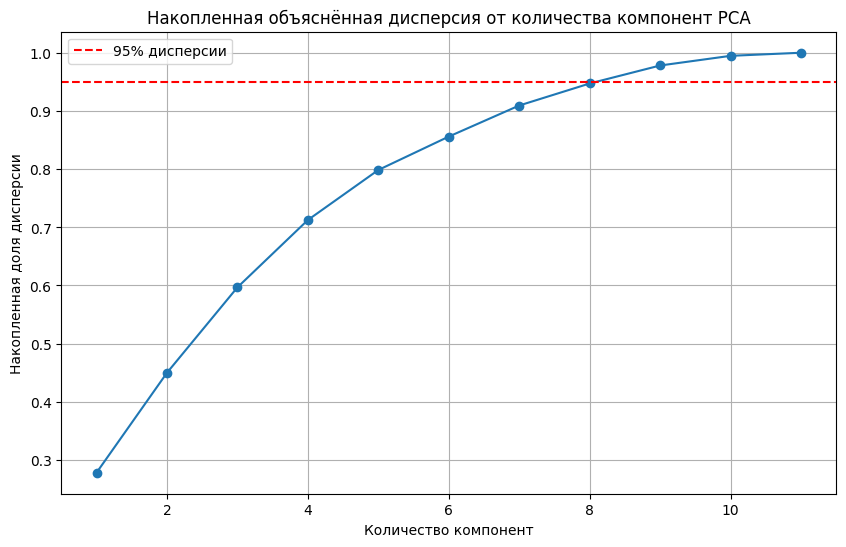

In [28]:
from sklearn.decomposition import PCA



# Инициализируем PCA без ограничения по числу компонент
pca = PCA()
pca.fit(X_train_scaled)

# Получим долю объяснённой дисперсии каждой компонентой
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Построим график накопленной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% дисперсии")
plt.title("Накопленная объяснённая дисперсия от количества компонент PCA")
plt.xlabel("Количество компонент")
plt.ylabel("Накопленная доля дисперсии")
plt.grid(True)
plt.legend()
plt.show()

Из графика видно, что:
	•	При 8 компонентах достигается примерно 95% объяснённой дисперсии.
	•	После 8 компонент кривая выходит на плато — прирост информации становится незначительным.
	•	Значит, 8 компонент — оптимальное количество, при котором мы сохраняем почти всю важную информацию, но при этом уменьшаем размерность с 11 до 8.

Мы выбираем 8 компонент для PCA-преобразования, потому что:
	•	Это позволяет сохранить баланс между размерностью и точностью.
	•	Мы сохраняем 95% всей информации, содержащейся в признаках.
	•	Это может уменьшить переобучение и ускорить обучение моделей, особенно ансамблевых.
	•	После 8 компонент информация добавляется очень незначительно, а сложность модели растёт.

## Обучение моделей на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Какой алгоритм справился лучше? Какой быстрее? Почему?

In [29]:
# Инициализируем и применим PCA с 8 компонентами
pca_final = PCA(n_components=8)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

tree = DecisionTreeRegressor(random_state=42)

# Сетка параметров
param_grid_tree = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV
grid_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring='r2', n_jobs=-1)
grid_tree.fit(X_train_pca, y_train)

# Результаты
print("Decision Tree R²:", round(grid_tree.best_score_, 4))
print("Лучшие параметры:", grid_tree.best_params_)



base_tree = DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base_tree, random_state=42)

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [3, 5]
}

grid_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='r2', n_jobs=-1)
grid_ada.fit(X_train_pca, y_train)

print("AdaBoost R²:", round(grid_ada.best_score_, 4))
print("Лучшие параметры:", grid_ada.best_params_)

Decision Tree R²: 0.2094
Лучшие параметры: {'max_depth': 3, 'min_samples_split': 2}
AdaBoost R²: 0.3179
Лучшие параметры: {'estimator__max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 50}


## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о моделях регрессии с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

#### До PCA:
DecisionTree R²: −0.2161 (перенастроенный с max_depth=5 дал чуть лучше)
AdaBoost R²: 0.3459 (после подбора гиперпараметров)

##### После PCA:
DecisionTree R²: 0.2094
AdaBoost R²: 0.3179

##### Вывод:
Качество AdaBoost немного снизилось после PCA (0.3459 - 0.3179), что логично, так как PCA может терять немного информации.
Зато DecisionTree сильно улучшился (−0.21 - 0.21), что говорит о том, что PCA помог устранить переобучение и шум.

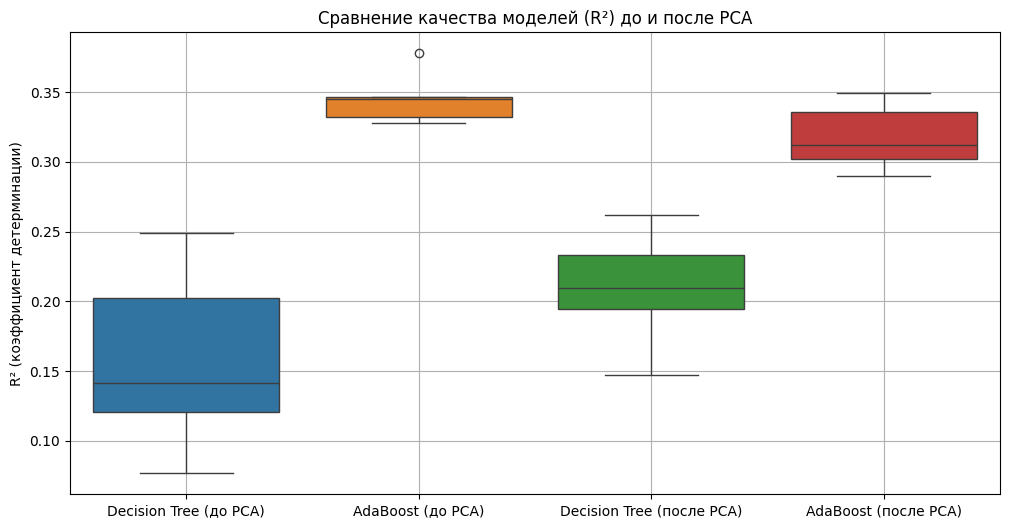

In [30]:
# Кросс-валидация лучшего дерева на PCA-преобразованных данных
tree_cv_pca = cross_validate(grid_tree.best_estimator_, X_train_pca, y_train, cv=5, scoring='r2')

# Кросс-валидация лучшего AdaBoost на PCA-преобразованных данных
ada_cv_pca = cross_validate(grid_ada.best_estimator_, X_train_pca, y_train, cv=5, scoring='r2') 

r2_data = pd.DataFrame({
    "Decision Tree (до PCA)": tree_cv['test_score'],
    "AdaBoost (до PCA)": ada_cv['test_score'],
    "Decision Tree (после PCA)": tree_cv_pca['test_score'],
    "AdaBoost (после PCA)": ada_cv_pca['test_score']
})

# Построим ящик с усами
plt.figure(figsize=(12, 6))
sns.boxplot(data=r2_data)
plt.title("Сравнение качества моделей (R²) до и после PCA")
plt.ylabel("R² (коэффициент детерминации)")
plt.grid(True)
plt.show()

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 30%). Не забудьте про все необходимые преобразования.

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Decision Tree на исходных данных (11 признаков)
tree_orig = DecisionTreeRegressor(max_depth=3, min_samples_split=2, random_state=42)
tree_orig.fit(X_train_scaled, y_train)

# AdaBoost на исходных данных
ada_orig = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
ada_orig.fit(X_train_scaled, y_train)

# Decision Tree на PCA-преобразованных данных (8 признаков)
tree_pca = DecisionTreeRegressor(max_depth=3, min_samples_split=2, random_state=42)
tree_pca.fit(X_train_pca, y_train)

# AdaBoost на PCA-преобразованных данных
ada_pca = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)
ada_pca.fit(X_train_pca, y_train)

# Предсказания
models_test = {
    "Decision Tree (до PCA)": (tree_orig, X_test_scaled),
    "AdaBoost (до PCA)": (ada_orig, X_test_scaled),
    "Decision Tree (после PCA)": (tree_pca, X_test_pca),
    "AdaBoost (после PCA)": (ada_pca, X_test_pca),
}

# Сбор метрик
results_test = []

for name, (model, X_t) in models_test.items():
    y_pred = model.predict(X_t)
    results_test.append({
    "Модель": name,
    "R²": round(r2_score(y_test, y_pred), 4),
    "MAE": round(mean_absolute_error(y_test, y_pred), 4),
    "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)

    })

# Таблица
display(pd.DataFrame(results_test))

,Модель,R²,MAE,RMSE
0,Decision Tree (до PCA),0.2755,0.5273,0.7002
1,AdaBoost (до PCA),0.4536,0.4798,0.6081
2,Decision Tree (после PCA),0.2676,0.5759,0.7040
3,AdaBoost (после PCA),0.4010,0.5116,0.6367


#### Почему DecisionTreeRegressor показывает другое значение?

#### 1. Изначальное значение -0.2161

Это был результат кросс-валидации (cross_val_score) на обучающих данных.
Кросс-валидация делит обучающую выборку на куски и оценивает устойчивость модели. Она может быть строже, особенно если модель нестабильна (как дерево без настройки).

#### 2. Новое значение 0.275

Это результат на тестовой выборке, которая:
	•	Не использовалась в обучении,
	•	Уже масштабирована,
	•	Модель уже подобрана по гиперпараметрам (max_depth=3, min_samples_split=2).